In [1]:
import torch 
ckpt_path = "/home/users/sai.kiran/workspace/projects/ssl_pretraining/EXPS/mae-qxr1/epoch=5-step=6000.ckpt"
ckpt = torch.load(ckpt_path)

In [2]:
ckpt.keys()

dict_keys(['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'loops', 'callbacks', 'optimizer_states', 'lr_schedulers', 'NativeMixedPrecisionPlugin', 'hparams_name', 'hyper_parameters'])

In [16]:
# conf is an omegaconf object
ckpt['hyper_parameters']['config'].dataset.image_size

512

In [8]:
from src.systems.pytorch import contpred, emix, mae, shed
# system = mae.MAESystem.load_from_checkpoint(ckpt) ---> doesn't work bcs it has callback statedict included too
system = mae.MAESystem(ckpt['hyper_parameters']['config'])
system.eval()

MAESystem(
  (model): DomainAgnosticTransformer(
    (embed_modules): ModuleList(
      (0): Input2dToEmbeddings(
        (embed): Sequential(
          (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=16, p2=16)
          (1): Linear(in_features=256, out_features=256, bias=True)
        )
      )
    )
    (dropout): Dropout(p=0.1, inplace=False)
    (transformer): Transformer(
      (layers): ModuleList(
        (0-11): 12 x ModuleList(
          (0): PreNorm(
            (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
            (fn): Attention(
              (attend): Softmax(dim=-1)
              (to_qkv): Linear(in_features=256, out_features=1536, bias=False)
              (to_out): Sequential(
                (0): Linear(in_features=512, out_features=256, bias=True)
                (1): Dropout(p=0.1, inplace=False)
              )
            )
          )
          (1): PreNorm(
            (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)

In [10]:
# All the things saved in the state_dict
set(i.split('.',1)[0] for i in ckpt['state_dict'].keys())

{'model', 'non_linear_evaluator', 'predictor'}

In [11]:
def get_state_dict(model_name, state_dict):
    return {k.split('.',1)[1]:v for k,v in state_dict.items() if k.startswith(model_name)}

In [24]:
model_state_dict = get_state_dict('model', ckpt['state_dict'])
system.model.load_state_dict(model_state_dict, strict=False)
predictor_state_dict = get_state_dict('predictor', ckpt['state_dict'])
system.predictor.load_state_dict(predictor_state_dict, strict=False)

<All keys matched successfully>

In [17]:
import cv2
import matplotlib.pyplot as plt
import torch
im_path = "/models_common_e2e/data/cxr_data/images/max.dev3.110785324.png"
im = cv2.imread(im_path, 0)
im_size = ckpt['hyper_parameters']['config'].dataset.image_size
im = cv2.resize(im, (im_size, im_size))

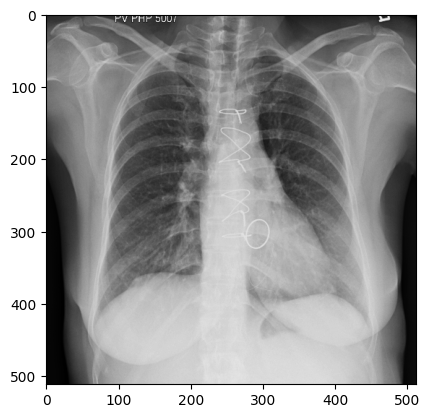

In [18]:
plt.imshow(im, cmap="gray")

In [19]:
x = torch.tensor(im).unsqueeze(0).unsqueeze(0).float()
x = (x - x.min()) / (x.max() - x.min())

In [51]:
# y = system.model.forward([x]) -> This gives pooled, mlp applied output
y = system.model.forward([x], prepool=True)
print(y.shape) # contains cls token too at position 0

torch.Size([1, 1025, 256])


In [52]:
# remove 0th element in 2nd dimension
y = y[:,1:,:]
pred = system.predictor.forward(y)

In [53]:
from einops.layers.torch import Rearrange
import torch.nn as nn
# creating image from encoder output 
reshape_to_image = nn.Sequential(
                Rearrange(
                    'b (h w) (p1 p2 c) -> b c (h p1) (w p2)', p1=16, p2=16, h=32, w=32, c=1
                )
            )
im_pred = reshape_to_image(pred)

In [54]:
im_pred.shape

torch.Size([1, 1, 512, 512])

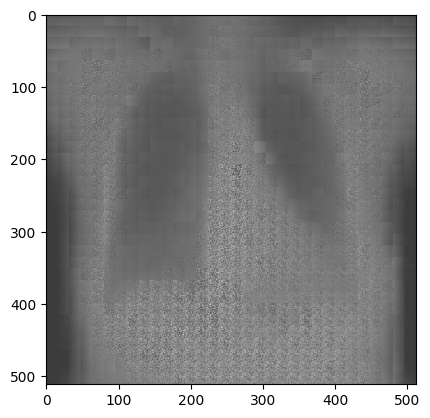

In [55]:
im_pred = im_pred.detach().numpy()
plt.imshow(im_pred[0][0], cmap="gray")

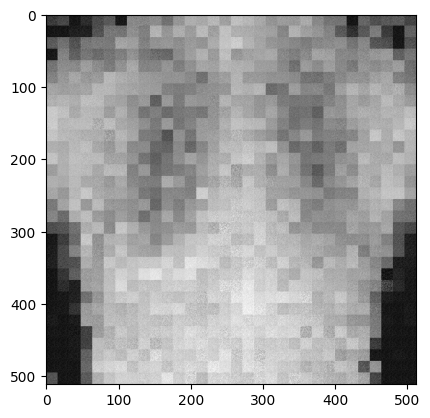

In [88]:
# output of epoch 0

In [28]:
from pytorch_lightning import Callback, LightningModule, Trainer
from src.datasets.catalog import DATASET_DICT

dataset = DATASET_DICT["qxr"](base_root="/models_common_e2e/data/cxr_data/", download=True, train=False)

In [47]:
import numpy as np
ids = np.random.randint(0, 1000, 10)
batch = [dataset[i] for i in ids]
batch = torch.stack([b[1] for b in batch])
print(batch.shape)

torch.Size([10, 1, 512, 512])


In [44]:
y1 = system.model.forward([batch], prepool=True)

In [45]:
y1.shape

torch.Size([10, 1025, 256])

In [1]:
import pandas as pd
import pickle 
import os, glob

In [2]:
files = glob.glob("/cache/datanas1/sai.kiran/fda/qxr_out/*")

In [3]:
d = pickle.load(open(files[0],"rb"))

In [4]:
d["cardiomegaly"]["ctr_coordinates"]

{'right_lung_corner': '(128, 1691)',
 'left_lung_corner': '(1817, 1691)',
 'heart_bounding_box': {'col_left': '663',
  'col_right': '1640',
  'row_top': '999',
  'row_bottom': '1667'}}

In [8]:
files[0].split("/")[-1].rsplit(".",1)[0]

'1.3.6.1.4.1.55648.147759100676467983526766269930089147063.1.1'

In [10]:
import ast
from tqdm import tqdm
def get_vals(s):
    return ast.literal_eval(s)

def get_coords(path):
    d = pickle.load(open(path,"rb"))
    coords = {}
    d = d["cardiomegaly"]["ctr_coordinates"]
    coords["lung_left_col"] = get_vals(d["left_lung_corner"])[0]
    coords["lung_left_row"] = get_vals(d["left_lung_corner"])[1]
    coords["lung_right_col"] = get_vals(d["right_lung_corner"])[0]
    coords["lung_right_row"] = get_vals(d["right_lung_corner"])[1]
    coords["heart_left_row"] = d["heart_bounding_box"]["row_top"]
    coords["heart_right_row"] = d["heart_bounding_box"]["row_bottom"]
    coords["heart_left_col"] = d["heart_bounding_box"]["col_left"]
    coords["heart_right_col"] = d["heart_bounding_box"]["col_right"]
    return coords

d = {}
for i in tqdm(files):
    d[i.split("/")[-1].rsplit(".",1)[0]] = get_coords(i)

100%|██████████| 1880/1880 [00:35<00:00, 53.06it/s]


In [11]:
d

{'1.3.6.1.4.1.55648.147759100676467983526766269930089147063.1.1': {'lung_left_col': 1817,
  'lung_left_row': 1691,
  'lung_right_col': 128,
  'lung_right_row': 1691,
  'heart_left_row': '999',
  'heart_right_row': '1667',
  'heart_left_col': '663',
  'heart_right_col': '1640'},
 '1.3.6.1.4.1.55648.121426867066046345058705679144277422216.1001.1001': {'lung_left_col': 2818,
  'lung_left_row': 2229,
  'lung_right_col': 448,
  'lung_right_row': 2229,
  'heart_left_row': '1271',
  'heart_right_row': '2167',
  'heart_left_col': '1312',
  'heart_right_col': '2100'},
 '1.3.6.1.4.1.55648.307900015748928155012811530400800604645.1001.1001': {'lung_left_col': 2737,
  'lung_left_row': 2023,
  'lung_right_col': 462,
  'lung_right_row': 2023,
  'heart_left_row': '1077',
  'heart_right_row': '2027',
  'heart_left_col': '1331',
  'heart_right_col': '2323'},
 '1.3.6.1.4.1.55648.61617839975040311903175439616682610559.1001.1001': {'lung_left_col': 2172,
  'lung_left_row': 2040,
  'lung_right_col': 115,
  

In [16]:
df = pd.DataFrame.from_dict(d, orient="index")

In [17]:
df.reset_index(inplace=True)

In [20]:
df.columns = ["SOPInstanceUID", "lung_left_col", "lung_left_row", "lung_right_col", "lung_right_row", "heart_left_row", "heart_right_row", "heart_left_col", "heart_right_col"]

In [21]:
df

,SOPInstanceUID,lung_left_col,lung_left_row,lung_right_col,lung_right_row,heart_left_row,heart_right_row,heart_left_col,heart_right_col
0,1.3.6.1.4.1.55648.1477591006764679835267662699...,1817,1691,128,1691,999,1667,663,1640
1,1.3.6.1.4.1.55648.1214268670660463450587056791...,2818,2229,448,2229,1271,2167,1312,2100
2,1.3.6.1.4.1.55648.3079000157489281550128115304...,2737,2023,462,2023,1077,2027,1331,2323
3,1.3.6.1.4.1.55648.6161783997504031190317543961...,2172,2040,115,2040,1302,2228,853,1942
4,1.3.6.1.4.1.55648.4115099990205116997057755510...,1958,2310,271,2310,1430,2230,947,1731
...,...,...,...,...,...,...,...,...,...
1875,1.3.6.1.4.1.55648.1882784880077775014435630443...,2588,1813,290,1813,1084,1854,1182,2158
1876,1.3.6.1.4.1.55648.2359670527922563862789745089...,2204,2043,83,2043,1295,2020,884,1973
1877,1.3.6.1.4.1.55648.9280191351547450836091865652...,1894,1778,271,1778,1072,1737,794,1564
1878,1.3.6.1.4.1.55648.3139472626484538171264355005...,1849,1660,207,1660,847,1596,856,1389


In [22]:
df.to_csv("/cache/datanas1/sai.kiran/fda/pred_coords.csv", index=False)